# I. Importing libraries

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, IBMQ
from qiskit.visualization import *

from qiskit.aqua.components import optimizers

# II. Background
MaxCut is a problem whose goal is to find a bipartition $\mathbf{x}$ of vertices in a weighted graph that maximizes $$C(\mathbf{x}) = \sum_{e \in \text{edges}} C_e(\mathbf{x}),$$ where $C$ is the total weight of edges cut given partition $\mathbf{x}$ as a bitstring. Here we only consider non-directional graphs. Let $A$ and $B$ be the two sets for the partition. The set $A$ contains $i$-th vertex if $\mathbf{x}_i = 0$ and $\mathbf{x}_i = 1$ for $B$. Given $e$ the edge between two vertices $v_i$ and $v_j$ with corresponding weight $w_{ij}$, $C_e(\mathbf{x}) = w_{ij}$ if $v_i$ and $v_j$ belongs to different sets $A$ and $B$; $C_e(\mathbf{x}) = 0$ otherwise.

Quantum Approximate Optimization Algorithm (QAOA) can be viewed as a form of Quantum Annealing that attempts to encode the optimal state (which gives optimal cuts) as the ground state of a Hamiltonian. Finding the maximal cut is equivalent to finding the ground state of $\displaystyle{H_C = -\frac{1}{2} \sum_{(v_i,v_j) \in \text{edges}} w_{ij}(1-\sigma_i^z\sigma_j^z)}$ in the transverse field induced by $\displaystyle{H_B = \sum_{v_i \in \text{vertices}} \sigma_i^x}$, where $\sigma$ are Pauli operators.

Starting from the uniform superposition $|+\rangle^{\otimes n}$, we evolve the system with $\displaystyle{U_{C_k} = e^{-i\gamma_k H_C}}$ and $\displaystyle{U_{B_k} = e^{-i\beta_k H_B}} $ for $k=1,2,\dots,p$ for some chosen depth $p$. The final state of the system is given by 
$$U_{B_p}U_{C_p}\dots U_{B_2}U_{C_2}U_{B_1}U_{C_1}|+\rangle^{\otimes n}$$

The technique is called trotterization, in which the ansatz state is prepared from $2p$ angles $\{\beta_k, \gamma_k\}$. While $U_{C_k}$ evolves the system simulating the desired Hamiltonian, $U_{B_k}$ is a driver keeping the system away from higher eigenstates. Measurement outcomes of all qubits in the $Z$ basis suffices to compute the cost function, which is the weighted sum of cut edges, that will be passed to a classical optimizer.

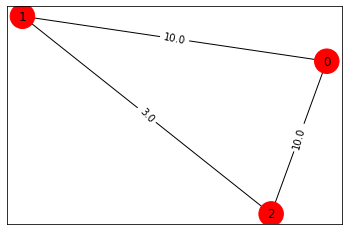

In [7]:
n = 3
V = np.arange(0,n,1)
E = [(0,1,10.0),(0,2,10.0),(1,2,3.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Plot the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)

In [8]:
def compute_cut_weight(G,partitions):
    """
    Return list of cut weights corresponding to input partitions
    
    Args:
        G : Graph
        A weighted graph
        
        partitions : list(str)
        List of bitstring   
    """
    
    vertices = list(G.nodes().keys())
    edges = G.edges()
    cut_vals = []
    
    for partition in partitions:
        cut = 0
        
        idx_A = [idx for idx,char in enumerate(partition) if char=='0']
        idx_B = [idx for idx,char in enumerate(partition) if char=='1']
        
        half_A = [vertices[i] for i in idx_A]
        half_B = [vertices[i] for i in idx_B]
        
        for v1 in half_A:
            for v2 in half_B:
                if (v1,v2) in edges:
                    cut += G[v1][v2]['weight']
        cut_vals.append(cut)
    
    return cut_vals

In [9]:
def classical_maxcut(G):
    """
    Return the maximum cut value and all cuts that produce the maximum value.
    
    Args:
        G : nx.Graph
        A weighted graph
    """
    n = len(G.nodes())
    partitions = []
    
    # Generate all bitstrings of length n
    for i in range(2**n):
        partitions.append(bin(i)[2:].zfill(n))
        
    cut_vals = compute_cut_weight(G,partitions)
    max_cut_val = max(cut_vals)
    
    max_cuts = [p for idx,p in enumerate(partitions) if cut_vals[idx] == max_cut_val]
    
    return max_cut_val, max_cuts

In [10]:
classical_maxcut(G)

(20.0, ['011', '100'])

# III. Implementation details
Because the terms $\sigma^z_i \sigma^z_j$ commute with each other (and similar for $\sigma^x_i$), we can write 
$$\begin{matrix}
U_{C_k} = & e^{-i\gamma_k H_C} = & \displaystyle{\prod_{(v_i,v_j) \in \text{edges}} e^{-i\gamma_k w_{ij}(1-\sigma_i^z\sigma_j^z)/2}}\\ 
U_{B_k} = & e^{-i\beta_k H_B} = & \displaystyle{\prod_{v_i \in \text{vertices}} e^{-i\beta_k \sigma_i^x}}
\end{matrix}$$

In Qiskit notion, $R_A(\theta) = e^{-i\frac{\theta}{2}A}$, where $A \in \{X,Y,Z\}$. The ansatz components can be decomposed into
$$\begin{matrix}
U_{C_k} = & \displaystyle{\prod_{(v_i,v_j) \in \text{edges}} CX_{ij}\cdot R_Z(-\gamma_k w_{ij}) } \cdot CX_{ij}
 \\
U_{B_k} = & \displaystyle{\prod_{v_i \in \text{vertices}}  R_{X_i}(-2\beta_k) }
\end{matrix}
$$

We also provide an option for non-uniform transverse field. The non-uniformity proves helpful for performance in complex/tricky cases. The field is induced by $H_C = \sum_{v_i \in \text{vertices}} i\sigma_i^x$ with corresponding operators
$$U_{B_k} = \displaystyle{\prod_{v_i \in \text{vertices}}  R_{X_i}(-2i\beta_k) }$$



In [11]:
class QAOA_Solver():
    """
    Create a quantum circuit that performs QAOA for an input graph
    
    Args:
        G : nx.Graph
        A weighted graph
            
    """
    def __init__(self,G):
        """
        Initialize (self) quantum circuit.
        """
        self.G = G
        self.V = G.nodes()
        self.E = G.edges()
        self.n = len(self.V)

        self._qreg = QuantumRegister(self.n, name='qreg')
        self._creg = ClassicalRegister(self.n, name='creg')
        self._circuit = QuantumCircuit(self._qreg, self._creg)
    
    def trotterize(self,depth,params=None,transverse='uniform'):  
        """
        Implement trotterization on the circuit.
        
        Args:
            depth : int
            Number of trotterization layers
            
            params : list((float,float)), optional
            Trotterization parameters, ideally of length = depth, with each pair is (beta_k,gamma_k) for layer k.
            If None, trotterization layers left parameterized.
            
            transverse : str, optional
            Type of transverse field.
            If uniform, the field Hamiltonian is uniform Pauli X's
            Otherwise, Hamiltonian is non-uniform.
        """
        
        betas = qiskit.circuit.ParameterVector('β', depth)
        gammas = qiskit.circuit.ParameterVector('γ', depth)       
        if params is not None:
            beta_values,gamma_values = list(zip(*params))
            assert len(betas) == depth, 'Obtain {} trotterization parameters but {} are expected'.format(len(params),depth)
        
        self._circuit.h(self._qreg)
        self._circuit.barrier()
        
        
        for d in range(depth):
            #self._circuit.rx(2*betas[d],self._qreg)
            ## Prepare U_C
            for edge in self.E:
                v1, v2 = edge
                w = G[v1][v2]['weight']
                self._circuit.cx(v1,v2)
                self._circuit.rz(-gammas[d]*w,v2)
                self._circuit.cx(v1,v2)
                
            self._circuit.barrier()
            
            ## Prepare U_B
            if transverse == 'uniform':
                self._circuit.rx(2*betas[d],self._qreg)      
            else:
                for idx,qubit in enumerate(self._qreg):
                    self._circuit.rx((idx+1)*2*betas[d],qubit)

            self._circuit.barrier()
                   
        if params is not None:
            self._circuit.assign_parameters({betas:list(beta_values), gammas:list(gamma_values)}, inplace=True)
            
        self._circuit.measure(self._qreg,self._creg)

    def get_circuit(self):
        """
        Return the quantum circuit.
        """
        return self._circuit
    
    def draw(self):
        """
        Draw the quantum circuit.
        """
        print(self._circuit.draw())
        

In [12]:
QAOA = QAOA_Solver(G)
QAOA.trotterize(3,transverse='uniform')
QAOA.draw()

        ┌───┐ ░                                                              »
qreg_0: ┤ H ├─░───■──────────────────────■────■──────────────────────■───────»
        ├───┤ ░ ┌─┴─┐┌────────────────┐┌─┴─┐  │                      │       »
qreg_1: ┤ H ├─░─┤ X ├┤ RZ(-10.0*γ[0]) ├┤ X ├──┼──────────────────────┼────■──»
        ├───┤ ░ └───┘└────────────────┘└───┘┌─┴─┐┌────────────────┐┌─┴─┐┌─┴─┐»
qreg_2: ┤ H ├─░─────────────────────────────┤ X ├┤ RZ(-10.0*γ[0]) ├┤ X ├┤ X ├»
        └───┘ ░                             └───┘└────────────────┘└───┘└───┘»
creg: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«                               ░ ┌────────────┐ ░                             »
«qreg_0: ───────────────────────░─┤ RX(2*β[0]) ├─░───■──────────────────────■──»
«                               ░ ├────────────┤ ░ ┌─┴─┐┌────────────────┐┌─┴─┐»
«qreg_1: ───────────────────■───░─┤ RX(2*β[0])

In [13]:
def loss_function(params,G,transverse='uniform',return_counts=False,backend=qiskit.Aer.get_backend("qasm_simulator"),shots= 10000):
    """
    Return the total loss given a graph and trotterization parameters.
    Total loss = - sum of weights of cut edges, averaged over measurement outcomes.
    
    Args:
        params : list(int)
        Ideally contain p beta values, followed by p gamma values.
        
        G : nx.Graph
        A weighted graph.
        
        transverse : str, optional
        Type of transverse field, either 'uniform' or else.
        More information can be found in QAOA_Solver class       
        
        return_counts : bool, optional
        If True, return statistics of experiment in addition.
        
        backend : `Qiskit backend`, optional
        Use local simulator by default.
        
        shots : int, optional
        The number experiment trials.
    """
    E = G.edges()
    V = G.nodes()
        
    
    # Convert params as a list to [(beta0,gamma0),(beta1,gamma1),...]
    depth = int(len(params) / 2)
    betas = params[:depth]
    gammas = params[depth:]
    params = list(zip(betas,gammas))
    
    QAOA = QAOA_Solver(G)
    QAOA.trotterize(depth, params, transverse)
    QAOA_circ = QAOA.get_circuit()
    job = execute(QAOA_circ, backend=backend, shots=shots)
    counts = job.result().get_counts()
    
    total_loss = 0
    
    for partition,count in counts.items():
        loss = 0
        for edge in E:
            v1,v2 = edge[0], edge[1]
            z1,z2 = -2*int(partition[v1])+1, -2*int(partition[v2])+1 # Map '0' to +1, '1' to -1
            w = G[v1][v2]['weight']
            loss += w*(1-z1*z2)
        loss = loss/2
        #print(partition, loss)
        total_loss += loss*(count/shots)
    
    if return_counts == False:
        return -total_loss
    else:
        return -total_loss,counts

In [14]:
def train(G,depth=1,transverse='uniform'):
    """
    Return optimal parameters and loss value after training a QAOA circuit
    
    Args:
        G : nx.Graph
        A weighted graph.
        
        depth : int
        The number of trotterization layers.
        
        transverse : str, optional
        Type of transverse field, either 'uniform' or else.
        More information can be found in QAOA_Solver class.
    """
    optimizer = optimizers.COBYLA()
    np.random.seed(20)
    init_params = np.random.rand(2*depth,)
    #print(init_params)

    opt_params,opt_loss,_ = optimizer.optimize(2*depth, optimizers.COBYLA.wrap_function(loss_function,args=(G,transverse)), initial_point=init_params)

    print('Optimal parameters = {}, optimal loss = {}'.format(opt_params,-opt_loss))
    
    return opt_params, -opt_loss

In [15]:
def evaluate_max_cut(G,counts,k=2):
    """
    Return k most probable cuts and their corresponding cut values
    
    Args: 
        G : nx.Graph
        A weighted graph.
        
        counts : dict(str: float)
        Statistics obtained from executing quantum circuit.
        
        k : int
        Number of selected probababilities.
        Note that the number of cuts can be > k if two cuts have the same probability.
    """
    sort_counts = sorted(set(counts.values()), reverse=True)

    #Get partitions with k highest probability
    partitions = []
    for i in range(k):
        partitions += [key for key,val in counts.items() if val==sort_counts[i]]
    cut_vals = compute_cut_weight(G,partitions)

    pairs = list(zip(partitions, cut_vals))
    return pairs

# IV. Experiments
We evaluate 4 graph configurations as follows

### 1. Uniformly butterfly graph
QAOA with uniform transverse field and a single trotterization layer is capable of peaking out 18 max cuts, better than the outcome obtained from the non-uniform one.

Maximum cut value = 4.0
Obtained by partitions ['00100', '00101', '00110', '01001', '01010', '01011', '01100', '01101', '01110', '10001', '10010', '10011', '10100', '10101', '10110', '11001', '11010', '11011']


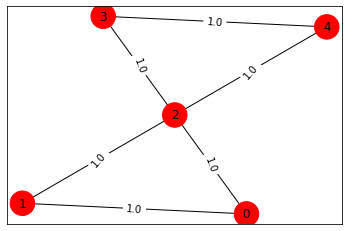

In [191]:
n = 5
V = np.arange(0,n,1)
E = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(2,3,1.0),(2,4,1.0),(3,4,1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)

# Compute max cuts classically
max_cut_val, max_cuts = classical_maxcut(G)
print("Maximum cut value = {}\nObtained by partitions {}".format(max_cut_val, max_cuts))

[0.5881308  0.89771373]
Optimal parameters = [1.87833965 0.61367107], optimal loss = 3.9284000000000003
Max Cut(s): [('11001', 4.0), ('01010', 4.0)]


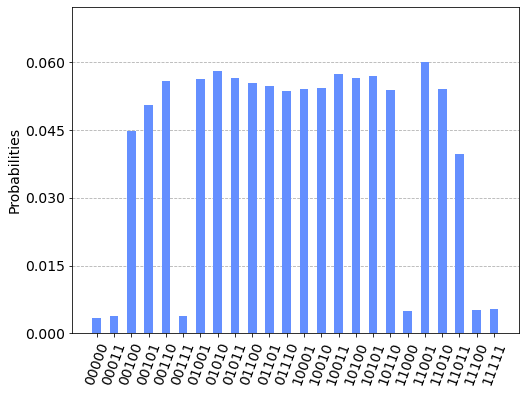

In [181]:
opt_params, opt_loss = train(G,depth=1, transverse='uniform')
loss, counts = loss_function(opt_params,G,return_counts=True, transverse='uniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

Optimal parameters = [1.06188104 1.41653876], optimal loss = 3.7532
Max Cut(s): [('01001', 4.0), ('10110', 4.0)]


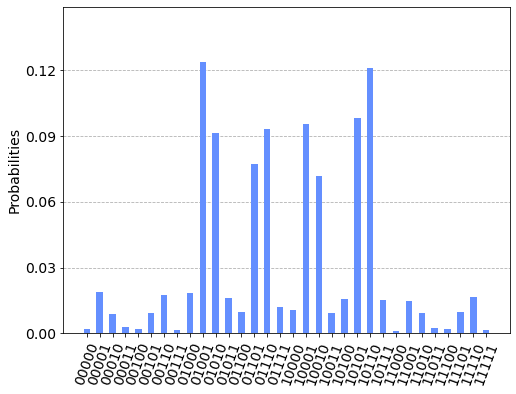

In [192]:
opt_params, opt_loss = train(G,depth=1, transverse='nonuniform')
loss, counts = loss_function(opt_params,G,return_counts=True, transverse='nonuniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

### 2.  Weighted square
Both types of transverse field work well given a sufficient number of layers

Maximum cut value = 10.0
Obtained by partitions ['0101', '1010']


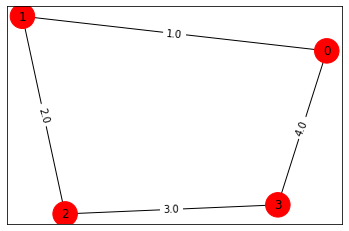

In [193]:
n = 4
V = np.arange(0,n,1)
E = [(0,1,1.),(1,2,2.),(2,3,3.),(3,0,4.)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)

# Compute max cuts classically
max_cut_val, max_cuts = classical_maxcut(G)
print("Maximum cut value = {}\nObtained by partitions {}".format(max_cut_val, max_cuts))

Optimal parameters = [ 0.7084594   1.02663722  0.44346084  1.26467133  0.39560086  0.61250296
  1.10706563  0.52375304  1.76964109 -0.11119655  0.18740231  0.68343664
  0.77256179  0.89416569  0.86144721  0.07137408], optimal loss = 9.989399999999998
Max Cut(s): [('1010', 10.0), ('0101', 10.0)]


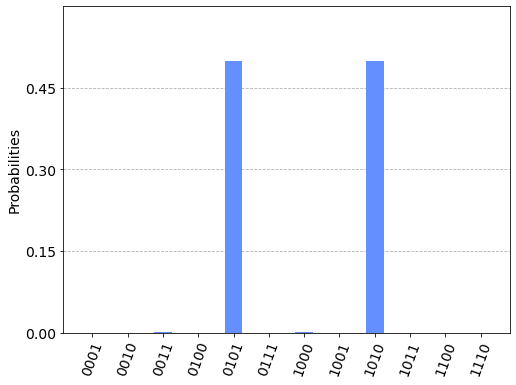

In [194]:
opt_params, opt_loss = train(G,depth=8,transverse='uniform')
loss, counts=loss_function(opt_params,G,return_counts=True,transverse='uniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

Optimal parameters = [ 1.49422632e+00  9.36902359e-01  8.96384367e-01  8.31067277e-01
  5.72839035e-04  6.68306677e-01  1.03506284e-01  5.74001813e-01
  6.56090435e-01  2.13130731e-01  1.21930274e+00  5.97022678e-01
  7.81064392e-01  8.67659051e-01  7.35593700e-01 -1.60627095e-01], optimal loss = 9.816299999999998
Max Cut(s): [('0101', 10.0), ('1010', 10.0)]


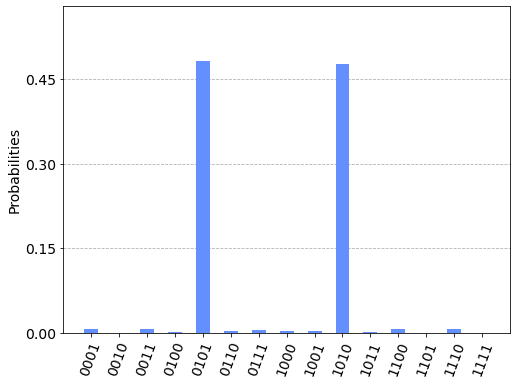

In [195]:
opt_params, opt_loss = train(G,depth=8,transverse='nonuniform')
loss, counts=loss_function(opt_params,G,return_counts=True,transverse='nonuniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

### 3. Weighted 3-regular graph
The uniform transverse field produces suboptimal outcomes. The non-uniform field typically results in better partitions

Maximum cut value = 52
Obtained by partitions ['01011101', '10100010']


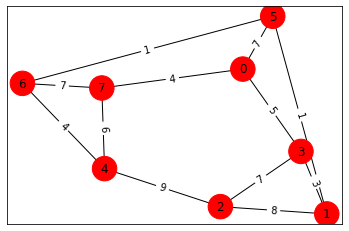

In [16]:
# Create 3-regular graph with sorted vertices
n = 8
temp_G = nx.random_regular_graph(3, n, seed=20)
V = np.arange(0,n,1)
E = list(temp_G.edges())

G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

np.random.seed(20)
weights = np.random.randint(1,10,(len(E),))
for idx,(v1,v2) in enumerate(G.edges()):
     G[v1][v2]['weight'] = weights[idx]

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)

# Compute max cuts classically
max_cut_val, max_cuts = classical_maxcut(G)
print("Maximum cut value = {}\nObtained by partitions {}".format(max_cut_val, max_cuts))

Optimal parameters = [1.60960902 0.9033521  1.90102428 0.79345654 1.03016224 0.65957486
 0.4083585  0.48580782 0.65186971 1.17825772 0.31368603 0.73325893
 1.83148464 1.84863199 1.77745153 0.02081137 0.11829601 0.77569414
 0.21873184 0.28318258 0.93069493 0.93927467 0.53923121 0.13008067
 0.78977216 0.49729807 0.59704104 1.83762842 0.46251084 0.48158634
 0.67135314 0.62116106 0.27341279 0.05776765 0.76204189 0.49999636
 0.33711092 0.50077325 0.27849123 0.31421659 0.64417659 0.59058625
 0.33271085 0.40038125 0.31501795 0.53847511 0.1554617  0.70141244
 0.73656883 0.16598905 0.71473371 0.40879856 0.79005427 0.80029364
 0.77776378 0.58515079 0.7134745  0.6350996  0.43188674 0.52265383
 0.52874168 0.00647863 0.70176167 0.64031847], optimal loss = 36.5523
Max Cut(s): [('11100010', 48), ('00011101', 48)]


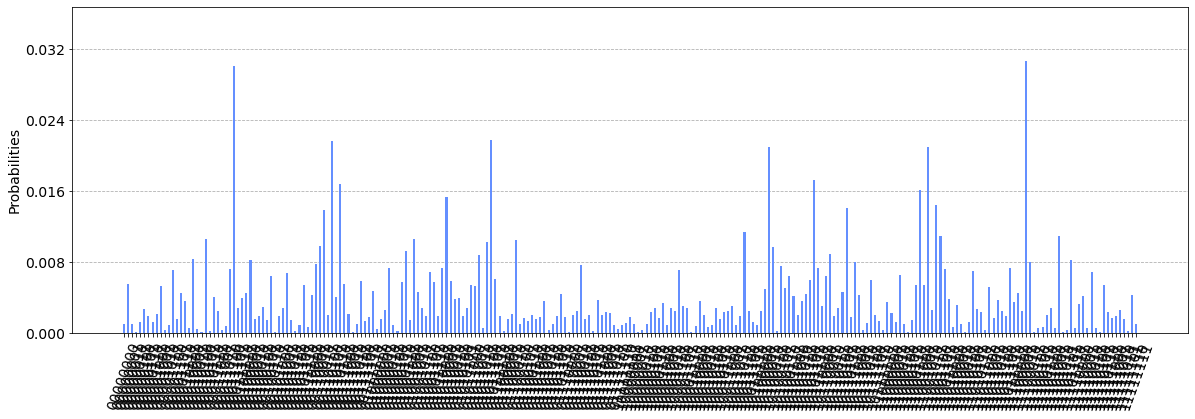

In [17]:
opt_params, opt_loss = train(G,depth=32,transverse='uniform')
loss, counts = loss_function(opt_params,G,return_counts=True,transverse='uniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (20,6),bar_labels = False)

Max Cut(s): [('01011101', 52), ('10100010', 52)]


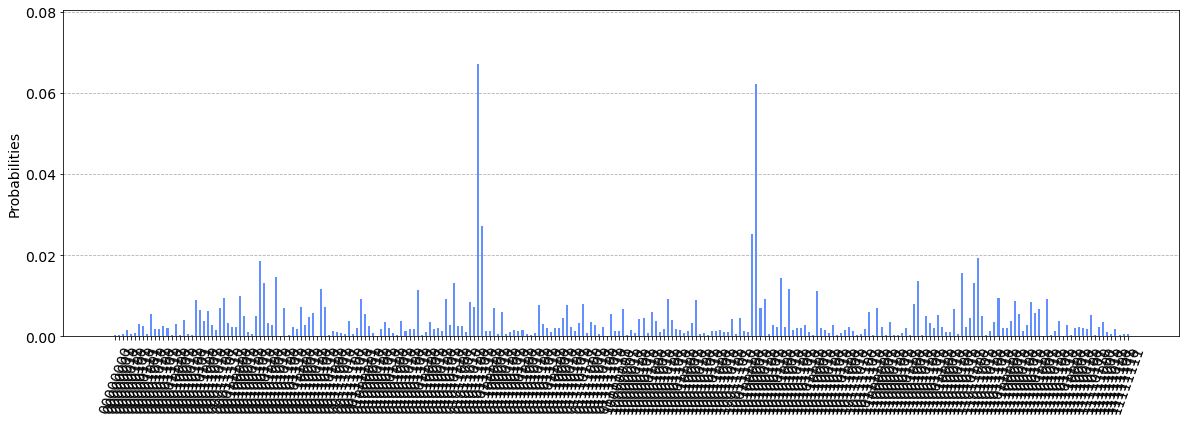

In [22]:
opt_params, opt_loss = train(G,depth=32,transverse='nonuniform')
loss, counts = loss_function(opt_params,G,return_counts=True,transverse='nonuniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (20,6),bar_labels = False)

### 4. Isosceles triangle
It turns out that the uniform transverse field performs poorly on a isosceles triangular graph regardless of trotterization depth. Probably the uniform field cannot push the state from some special uniform superposition. The non-uniform field works perfectly for this case even with fewer layers.

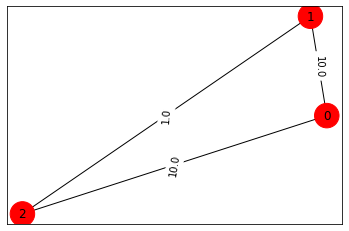

In [199]:
n = 3
V = np.arange(0,n,1)
E = [(0,1,10.),(0,2,10.),(1,2,1.)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)

Optimal parameters = [1.58930594 1.89948025 0.88985173 0.82862606 1.28734364 1.44247903
 0.38024053 0.51945377 0.65600073 0.19499105 0.02444793 0.71902883
 0.78105748 0.88738923 0.77564172 0.03712809 0.11715924 0.75174777
 0.23969551 0.25525701 0.85808195 0.95021234 0.56213966 0.17923034], optimal loss = 15.4319
Max Cut(s): [('010', 11.0), ('100', 20.0)]


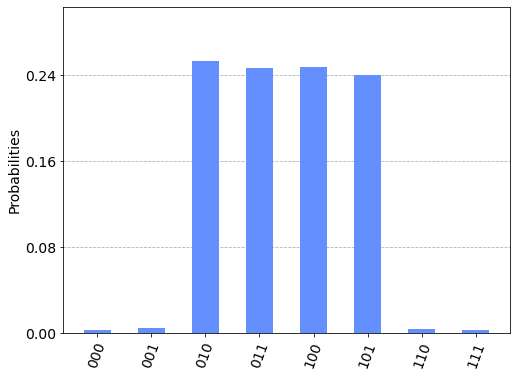

In [200]:
opt_params, opt_loss = train(G,depth=12,transverse='uniform')
loss, counts = loss_function(opt_params,G,return_counts=True,transverse='uniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

Optimal parameters = [ 0.5891035   0.91995814  1.930137    0.47110253 -0.02629345  0.72578021
  0.40984399  0.52026338  0.75269843  0.13024709  1.26333661  0.67769352], optimal loss = 19.9342
Max Cut(s): [('011', 20.0), ('100', 20.0)]


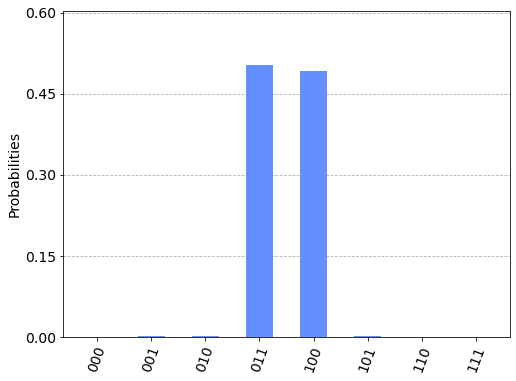

In [206]:
opt_params, opt_loss = train(G,depth=6,transverse='nonuniform')
loss, counts = loss_function(opt_params,G,return_counts=True,transverse='nonuniform')
pairs = evaluate_max_cut(G,counts)   
print("Max Cut(s): {}".format(pairs))
plot_histogram(counts,figsize = (8,6),bar_labels = False)